In [1]:
import os
import random
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

2025-09-10 15:21:15.354393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1


In [3]:
def preprocess_image(file):
    img_path = "data/mobilenet"
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [4]:
from IPython.display import Image

Image(filename='data/1/IMG_1119.JPG')

FileNotFoundError: [Errno 2] No such file or directory: 'data/1/IMG_1119.JPG'

#### Data Preparation

In [ ]:
os.chdir("data")
if not os.path.isdir("train/0"):
    os.mkdir("train")
    os.mkdir("valid")
    os.mkdir("test")

    for i in range(0, 10):
        shutil.move(f"{i}", "train")
        os.mkdir(f"valid/{i}")
        os.mkdir(f"test/{i}")

        k = len(os.listdir(f"train/{i}/"))
        valid_samples = random.sample(os.listdir(f"train/{i}"), k * 20 // 100)
        for j in valid_samples:
            shutil.move(f"train/{i}/{j}", f"valid/{i}")
        test_samples = random.sample(os.listdir(f"train/{i}"), k * 20 // 100)
        for j in test_samples:
            shutil.move(f"train/{i}/{j}", f"test/{i}")
os.chdir("..")

#### Data Generators

In [5]:
train_dir = "data/train"
valid_dir = "data/valid"
test_dir = "data/test"

In [6]:
train_batches = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2

).flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=10,

)

valid_batches = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
).flow_from_directory(
    directory=valid_dir,
    target_size=(224, 224),
    batch_size=10
)

test_batches = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
).flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=10,
    shuffle=False
)

Found 1244 images belonging to 10 classes.
Found 409 images belonging to 10 classes.
Found 409 images belonging to 10 classes.


#### Model Creation

In [7]:
mobile = tf.keras.applications.mobilenet.MobileNet()

I0000 00:00:1757506889.899837  664069 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4081 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
mobile.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [13]:
x = mobile.layers[-5].output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(10, activation='softmax')(x)

In [14]:
model = tf.keras.models.Model(inputs=mobile.input, outputs=output)

In [15]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,239,114 (12.36 MB)

 Trainable params: 1,872,906 (7.14 MB)

 Non-trainable params: 1,366,208 (5.21 MB)

#### Training

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:

3e-4

0.0003

In [30]:
model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=10,
    verbose=2
)

Epoch 1/10
125/125 - 8s - 64ms/step - accuracy: 0.9839 - loss: 0.0387 - val_accuracy: 0.9927 - val_loss: 0.0335
Epoch 2/10
125/125 - 8s - 61ms/step - accuracy: 0.9904 - loss: 0.0453 - val_accuracy: 0.9633 - val_loss: 0.1005
Epoch 3/10
125/125 - 8s - 62ms/step - accuracy: 0.9855 - loss: 0.0450 - val_accuracy: 0.9829 - val_loss: 0.0349
Epoch 4/10
125/125 - 8s - 60ms/step - accuracy: 0.9936 - loss: 0.0242 - val_accuracy: 0.9731 - val_loss: 0.0809
Epoch 5/10
125/125 - 8s - 61ms/step - accuracy: 0.9912 - loss: 0.0309 - val_accuracy: 0.9902 - val_loss: 0.0370
Epoch 6/10
125/125 - 8s - 65ms/step - accuracy: 0.9815 - loss: 0.0645 - val_accuracy: 0.9927 - val_loss: 0.0319
Epoch 7/10
125/125 - 8s - 64ms/step - accuracy: 0.9847 - loss: 0.0400 - val_accuracy: 0.9682 - val_loss: 0.0861
Epoch 8/10
125/125 - 8s - 63ms/step - accuracy: 0.9879 - loss: 0.0395 - val_accuracy: 0.9829 - val_loss: 0.0524
Epoch 9/10
125/125 - 8s - 64ms/step - accuracy: 0.9920 - loss: 0.0278 - val_accuracy: 0.9951 - val_loss:

In [31]:
# save model for later use
model.save("mobilenet_sign_digits.keras")

#### testing

In [20]:
test_lables = test_batches.classes

In [21]:
predictions = model.predict(x=test_batches, verbose=0)

In [22]:
cm = tf.math.confusion_matrix(labels=test_lables, predictions=predictions.argmax(axis=1))

In [23]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [24]:
cm_plot_labels = [i for i in range(10)]


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    import matplotlib.pyplot as plt

    # if normalize:
    #     cm = cm.numpy().astype('float') / cm.numpy().sum(axis=1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' if normalize else 'd'
    if normalize:
        thresh = cm.max() / 2.0
    else:
        thresh = cm.numpy().max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

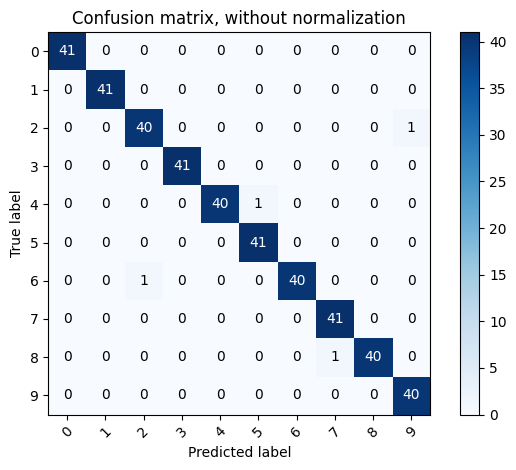

In [26]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix, without normalization')